## Bag of Words

In this notebook, I'll be attempting to predict movie review sentiments using a bag of words model. This model does not look at the context of words in reviews, only their presence and frequency. Hopefully, by classifying reviews based on features corresponding to the frequency of each word will yield somewhat accurate results.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
train = pd.read_csv('../../data/train.tsv', sep='\t')
test = pd.read_csv('../../data/test.tsv', sep='\t')
train.shape

/home/isaac/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(156060, 4)

### Count Vectorization

Our first attempt at feature extraction will be using the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) from [scikit-learn](http://scikit-learn.org/stable/index.html). This tool will look at each review and count the number of times each word occurs. The number of times a word appears in a review will hopefully correlate with the sentiment of the review.

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

subset = train[:2000]

# Create the vectorizer
# We ignoring common english words and only look at a maximum of 500 unique words
vectorizer = CountVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(subset.Phrase)

### Learning

Now that we've extracted our features, we can learn from them.

In [3]:
def cv(X, y):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.svm import SVC

    forest = RandomForestClassifier(n_estimators=500)
    boost = AdaBoostClassifier()
    svc = SVC()

    from sklearn.cross_validation import cross_val_score
    import time

    t0 = time.time()
    print "Random Forest cross validation runnning..."
    forest_score = cross_val_score(forest, X, y).mean()
    print "Random Forest Score: %2.2f" % forest_score
    print "dt: %f" % (time.time() - t0)
    print ""

    t0 = time.time()
    print "AdaBoost cross validation runnning..."
    boost_score = cross_val_score(boost, X, y).mean()
    print "AdaBoost Score:      %2.2f" % boost_score
    print "dt: %f" % (time.time() - t0)
    print ""

    t0 = time.time()
    print "SVC cross validation runnning..."
    svc_score = cross_val_score(svc, X, y).mean()
    print "SVC Score:           %2.2f" % svc_score
    print "dt: %f" % (time.time() - t0)
    print ""
    
cv(X, subset.Sentiment)

Random Forest cross validation runnning...
Random Forest Score: 0.59
dt: 18.166334

AdaBoost cross validation runnning...
AdaBoost Score:      0.62
dt: 0.668691

SVC cross validation runnning...
SVC Score:           0.63
dt: 0.555329



Sentiment Percentages


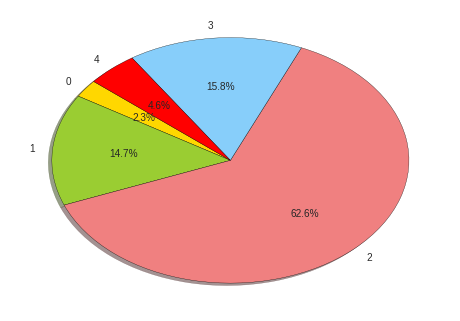

In [4]:
print "Sentiment Percentages"

sentiment_sizes = subset.groupby('Sentiment').size()
labels = map(str, range(5))
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red']
plt.pie(sentiment_sizes, autopct='%1.1f%%', colors=colors, labels=labels, shadow=True, startangle=140)
plt.show()

Our best cross validation scores are around 63%. This is oddly similar to the percent of Sentiments labeled as 2. It seems likely that our model is nearly always predicting a sentiment of 2 for every phrase.

### Kaggle Submission

Let's see how our bag of words model performs with count vectorization on kaggle.

In [12]:
from sklearn.svm import SVC

subset = train

# vectorize words
print 'vectorizing...'
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(subset.Phrase)
y = subset.Sentiment

# train the model
print 'fitting model...'
svc = SVC()
svc.fit(X, y)

# make predictions
print 'predicting...'
X = vectorizer.transform(test.Phrase)
y_pred = svc.predict(X)

# save results
results = pd.DataFrame({
    'PhraseId': test.PhraseId,
    'Sentiment': y_pred
})
results.to_csv('count_vectorize_bow.csv', index=False)

print 'done!'

vectorizing...
fitting model...
predicting...
done!


### How'd we do?

![Kaggle Score](count-kaggle-score.png)

### TF-IDF Vectorization

Vectorization only using the frequency of each word did not perform very well. By incorporating the inverse document frequency, we might better evaluate the significance of words in each review. This works by comparing the frequency of each word with the number of times it appears within all the reviews. If every review contains a certain word, then that word probably has a lower significance. This vectorization would reflect that. We will use the [TF-IDF Vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from [scikit-learn](http://scikit-learn.org/stable/index.html).

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the vectorizer
# We ignoring common english words and only look at a maximum of 500 unique words
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(subset.Phrase).toarray()

In [7]:
cv(X, subset.Sentiment)

Random Forest cross validation runnning...
Random Forest Score: 0.65
dt: 10.404664

AdaBoost cross validation runnning...
AdaBoost Score:      0.67
dt: 0.549418

SVC cross validation runnning...
SVC Score:           0.67
dt: 0.558865



It appears that TF-IDF vectorization slightly improved the scores of our Random Forest and AdaBoost models. Maybe if we use more of the training data, we will get even better results.

### Kaggle Submission

Now we'll train our model using TF-IDF vectorization.

In [11]:
from sklearn.svm import SVC

# vectorize words
print 'vectorizing...'
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(train.Phrase)
y = train.Sentiment

# train the model
print 'fitting model...'
svc = SVC()
svc.fit(X, y)

# make predictions
print 'predicting...'
X = vectorizer.transform(test.Phrase)
y_pred = svc.predict(X)

# save results
results = pd.DataFrame({
    'PhraseId': test.PhraseId,
    'Sentiment': y_pred
})
results.to_csv('tfidf_vectorize_bow.csv', index=False)

print 'done!'

vectorizing...
fitting model...
predicting...
done!


### How'd we do?

![Kaggle Score](tfidf-kaggle-score.png)

## Conclusion

At this point, it appears that a simple bag of words model with count vectorization or TF-IDF vectorization does not score much better than simply always predicting a sentiment of 2. In these tests only a portion of the training data set was used. By using a larger portion of data these results might change.